## Set up initial functions

In [32]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
import time
import pickle
from scipy.ndimage.measurements import label
from collections import deque
model_filename = 'finalized_model.sav'


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def getRGBImage(image_name):
    return mpimg.imread(image_name)

def rgb2hsv_schannel(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    s_channel = hsv[:,:,1]
    return s_channel

def rgb2luv_vchannel(img):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)
    v_channel = luv[:,:,2]
    return l_channel


def extract_features(images, cspace='RGB', orient=8, spatial_size=(32, 32),
                     hist_bins=32, pix_per_cell=8, cell_per_block=2,
                     spatial_feat=True, hist_feat=True, hog_feat=True,
                     hog_channel=0):
    features = []
    # Iterate through the list of images
    for image in images:
        file_features = []

        # load image
        if type(image) == str:
            image = getRGBImage(image)

        # convert color space
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            # 6) Append features to list
            file_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell,
                                                     cell_per_block, vis=False,
                                                     feature_vec=True))
            hog_features = np.ravel(hog_features)
            file_features.append(hog_features)
        else:
            hog_features=get_hog_features(feature_image[:,:,hog_channel],orient,
                                          pix_per_cell, cell_per_block,
                                          vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return np.array(features)

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        accuracy_prediction = clf.decision_function(test_features)
        #7) If positive (prediction == 1) then save the window
        if accuracy_prediction >= 0.8:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_hot_windows(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    on_windows = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(( hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def subtract_heat(heatmap):
    # subtract 1 for all pixels
    heatmap[heatmap > 0] -= 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (200,0,200), 3)
    # Return the image
    return img

def get_windows(img):
    y_start_stop1 = [400, 512]
    x_start_stop1 = [200, 1100]
    xy_window1 = (72,56)
    xy_overlap1 = (0.75,0.7)
    windows1 = slide_window(img, x_start_stop=x_start_stop1, y_start_stop=y_start_stop1, 
                        xy_window=xy_window1, xy_overlap=xy_overlap1)

    y_start_stop2 = [380, 592]
    x_start_stop2 = [0, 1280]
    xy_window2 = (120,100)
    xy_overlap2 = (0.7,0.7)
    windows2 = slide_window(img, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                        xy_window=xy_window2, xy_overlap=xy_overlap2)

    y_start_stop3 = [400, 720]
    x_start_stop3 = [None, None]
    xy_window3 = (200,180)
    xy_overlap3 = (0.75,0.5)
    windows3 = slide_window(img, x_start_stop=x_start_stop3, y_start_stop=y_start_stop3, 
                        xy_window=xy_window3, xy_overlap=xy_overlap3)

    all_windows = windows1 + windows2 + windows3
    return all_windows
print('All Clear')

All Clear


## Demonstrate a visualization of HOG features

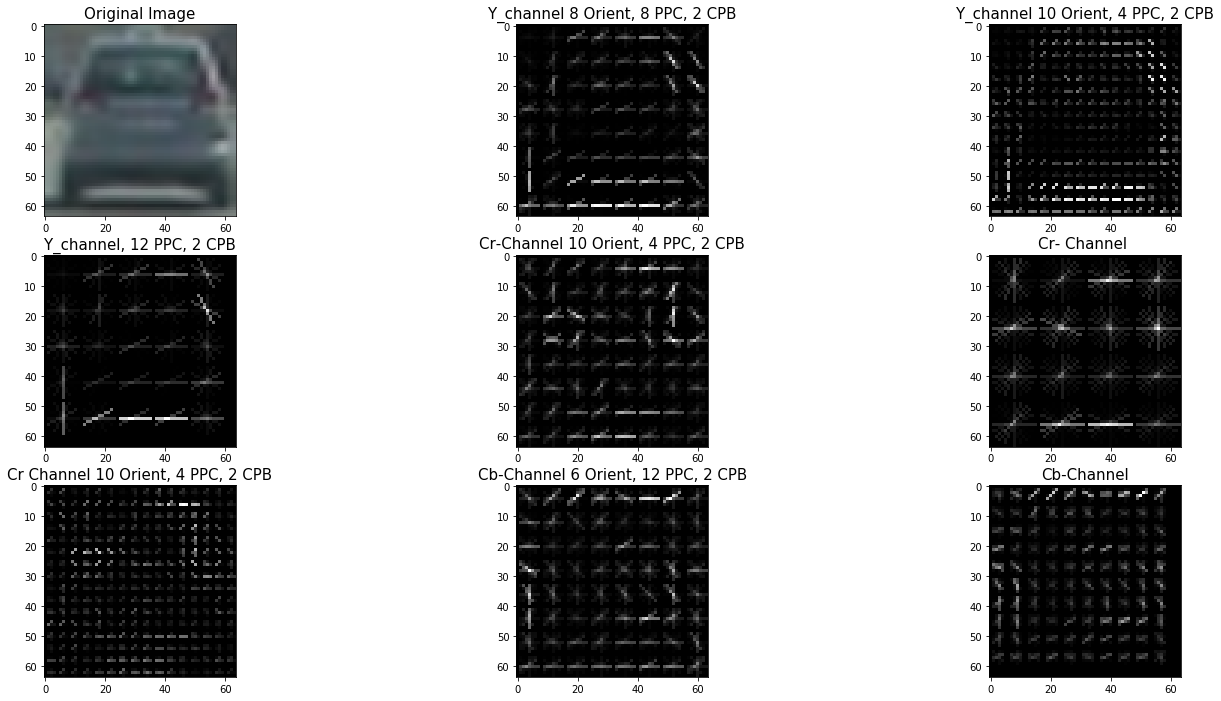

In [81]:
%matplotlib inline
cars = glob.glob("./vehicles/vehicles/**/*.png")
notcars = glob.glob("./non-vehicles/non-vehicles/**/*.png")

car_img1 = getRGBImage(cars[3])
notcar_img1 = getRGBImage(notcars[3])
YCrCbImg = convert_color(car_img1)
Y_channel = YCrCbImg[:,:,0]
Cr_channel = YCrCbImg[:,:,1]
Cb_channel = YCrCbImg[:,:,2]

features1, car_img_hog1 = get_hog_features(Y_channel, 8, 8, 2, True, True)
features5, car_img_hog5 = get_hog_features(Y_channel, 10, 4, 2, True, True)
features6, car_img_hog6 = get_hog_features(Y_channel, 6, 12, 2, True, True)

features2, car_img_hog2 = get_hog_features(Cr_channel, 8, 8, 2, True, True)
features8, car_img_hog8 = get_hog_features(Cr_channel, 10, 16, 2, True, True)
features4, car_img_hog4 = get_hog_features(Cr_channel, 10, 4, 2, True, True)

features3, car_img_hog3 = get_hog_features(Cb_channel, 8, 8, 2, True, True)
features7, car_img_hog7 = get_hog_features(Cb_channel, 9, 6, 2, True, True)

f, axs = plt.subplots(3, 3, figsize=(24, 12))
axs[0,0].imshow(car_img1)
axs[0,0].set_title('Original Image', fontsize=15)
axs[0,1].imshow(car_img_hog1, cmap='gray')
axs[0,1].set_title('Y_channel 8 Orient, 8 PPC, 2 CPB', fontsize=15)
axs[0,2].imshow(car_img_hog5, cmap='gray')
axs[0,2].set_title('Y_channel 10 Orient, 4 PPC, 2 CPB', fontsize=15)
axs[1,0].imshow(car_img_hog6, cmap='gray')
axs[1,0].set_title('Y_channel, 12 PPC, 2 CPB', fontsize=15)
axs[1,1].imshow(car_img_hog2, cmap='gray')
axs[1,1].set_title('Cr-Channel 10 Orient, 4 PPC, 2 CPB', fontsize=15)
axs[1,2].imshow(car_img_hog8, cmap='gray')
axs[1,2].set_title('Cr- Channel ', fontsize=15)
axs[2,0].imshow(car_img_hog4, cmap='gray')
axs[2,0].set_title('Cr Channel 10 Orient, 4 PPC, 2 CPB', fontsize=15)
axs[2,1].imshow(car_img_hog3, cmap='gray')
axs[2,1].set_title('Cb-Channel 6 Orient, 12 PPC, 2 CPB', fontsize=15)
axs[2,2].imshow(car_img_hog7, cmap='gray')
axs[2,2].set_title('Cb-Channel', fontsize=15)

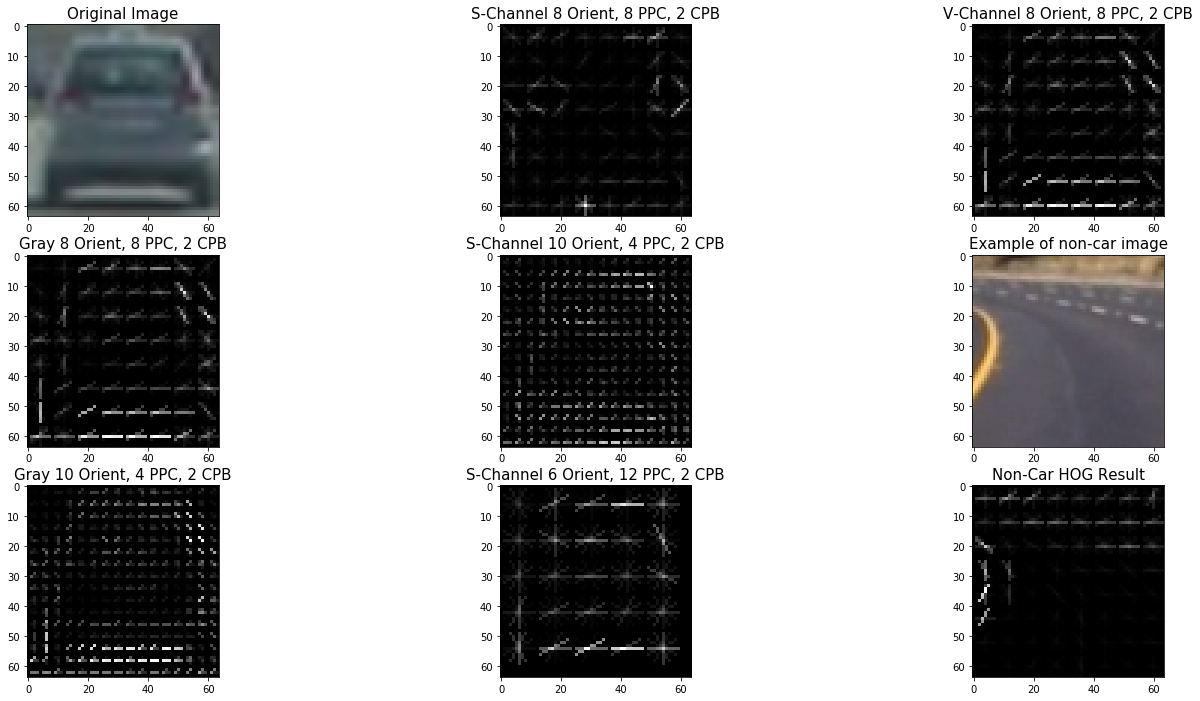

In [47]:
%matplotlib inline
cars = glob.glob("./vehicles/vehicles/**/*.png")
notcars = glob.glob("./non-vehicles/non-vehicles/**/*.png")

car_img1 = getRGBImage(cars[3])
notcar_img1 = getRGBImage(notcars[3])

s_channel_car1 = rgb2hsv_schannel(car_img)
features1, car_img_hog1 = get_hog_features(s_channel_car1, 8, 8, 2, True, True)
features5, car_img_hog5 = get_hog_features(s_channel_car1, 10, 4, 2, True, True)
features6, car_img_hog6 = get_hog_features(s_channel_car1, 6, 12, 2, True, True)
gray_car1 = cv2.cvtColor(car_img1, cv2.COLOR_RGB2GRAY)
gray_notcar = cv2.cvtColor(notcar_img1, cv2.COLOR_RGB2GRAY)
features2, car_img_hog2 = get_hog_features(gray_car1, 8, 8, 2, True, True)
features8, notcar_img_hog = get_hog_features(gray_notcar, 8, 8, 2, True, True)
features4, car_img_hog4 = get_hog_features(gray_car1, 10, 4, 2, True, True)
v_channel_car1 = rgb2luv_lchannel(car_img1)
features3, car_img_hog3 = get_hog_features(v_channel_car1, 8, 8, 2, True, True)
features7, car_img_hog7 = get_hog_features(v_channel_car1, 9, 6, 2, True, True)

f, axs = plt.subplots(3, 3, figsize=(24, 12))
axs[0,0].imshow(car_img)
axs[0,0].set_title('Original Image', fontsize=15)
axs[0,1].imshow(car_img_hog, cmap='gray')
axs[0,1].set_title('S-Channel 8 Orient, 8 PPC, 2 CPB', fontsize=15)
axs[0,2].imshow(car_img_hog3, cmap='gray')
axs[0,2].set_title('V-Channel 8 Orient, 8 PPC, 2 CPB', fontsize=15)
axs[1,0].imshow(car_img_hog2, cmap='gray')
axs[1,0].set_title('Gray 8 Orient, 8 PPC, 2 CPB', fontsize=15)
axs[1,1].imshow(car_img_hog5, cmap='gray')
axs[1,1].set_title('S-Channel 10 Orient, 4 PPC, 2 CPB', fontsize=15)
axs[1,2].imshow(notcar_img1, cmap='gray')
axs[1,2].set_title('Example of non-car image', fontsize=15)
axs[2,0].imshow(car_img_hog4, cmap='gray')
axs[2,0].set_title('Gray 10 Orient, 4 PPC, 2 CPB', fontsize=15)
axs[2,1].imshow(car_img_hog6, cmap='gray')
axs[2,1].set_title('S-Channel 6 Orient, 12 PPC, 2 CPB', fontsize=15)
axs[2,2].imshow(notcar_img_hog, cmap='gray')
axs[2,2].set_title('Non-Car HOG Result', fontsize=15)

In [52]:
cars = glob.glob("./vehicles/vehicles/**/*.png")
notcars = glob.glob("./non-vehicles/non-vehicles/**/*.png")
data_info = data_look(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])




Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


## Train the classifier

In [2]:
cars = glob.glob("./vehicles/vehicles/**/*.png")
notcars = glob.glob("./non-vehicles/non-vehicles/**/*.png")

extracted_car_features = extract_features(cars, cspace = 'YCrCb', orient=8, spatial_size=(16,16), hist_bins=18, pix_per_cell = 8, cell_per_block =2,
                                          spatial_feat=True, hist_feat=True, hog_feat=True, hog_channel='ALL')
extracted_notcar_features = extract_features(notcars, cspace = 'YCrCb', orient=8, spatial_size=(16,16), hist_bins=18, pix_per_cell = 8, cell_per_block =2,
                                          spatial_feat=True, hist_feat=True, hog_feat=True, hog_channel='ALL')

X_features = np.vstack((extracted_car_features, extracted_notcar_features)).astype(np.float64)
y_features = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

#Split training set from testing set
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                             test_size=0.2, random_state=28)

print('Done')

Done


In [3]:
# normalize the features using a standard scaler
X_scaler = StandardScaler().fit(X_features)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
print('Feature vector length:', len(X_train[0]))
t=time.time()
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to fit classifier')

pickle.dump(clf, open(model_filename, 'wb'))

print('done')

Feature vector length: 5526
12.39704 Seconds to fit classifier
done


In [3]:
clf = pickle.load(open(model_filename, 'rb'))
print('Classifier loaded')

Classifier loaded


In [4]:
print('Test Accuracy: ', round(clf.score(X_test, y_test), 3)) #0.992 on hog channel all using YCrCb, 0.973 on hog channel 0, and 1
#0.986 after removing spatial features
#0.986 on Y-channel including spatial features
#0.992 on ALL with YCrCb



Test Accuracy:  0.992


In [5]:
t=time.time()
n_predict = 10
print('My SVC predicts:    ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print('With accuracy:      ', clf.decision_function(X_test[0:n_predict]))
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:     [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
With accuracy:       [-3.12827006 -2.13843557  3.60803024  2.47615659 -3.31944767  3.33174151
  2.40252544 -3.5792842   3.52394716  0.31587947]
0.00199 Seconds to predict 10 labels with SVC


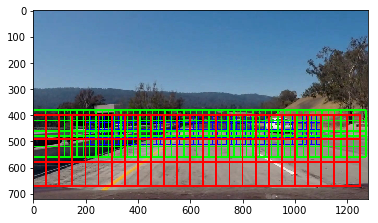

In [21]:
%matplotlib inline
test_image = getRGBImage('./test_images/test7.jpg')
#Could use the img_size to make dynamic start stop pixel values. Deciding to hard code for now.
draw_image = np.copy(test_image)
img = draw_image.astype(np.float32) / 255

y_start_stop1 = [400, 512]
x_start_stop1 = [200, 1100]
xy_window1 = (72,56)
xy_overlap1 = (0.75,0.5)
windows1 = slide_window(img, x_start_stop=x_start_stop1, y_start_stop=y_start_stop1, 
                    xy_window=xy_window1, xy_overlap=xy_overlap1)

y_start_stop2 = [380, 592]
x_start_stop2 = [0, 1280]
xy_window2 = (120,100)
xy_overlap2 = (0.6,0.6)
windows2 = slide_window(img, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                    xy_window=xy_window2, xy_overlap=xy_overlap2)

y_start_stop3 = [400, 720]
x_start_stop3 = [None, None]
xy_window3 = (200,180)
xy_overlap3 = (0.75,0.5)
windows3 = slide_window(img, x_start_stop=x_start_stop3, y_start_stop=y_start_stop3, 
                    xy_window=xy_window3, xy_overlap=xy_overlap3)

all_windows = windows1 + windows2 + windows3

window_img1 = draw_boxes(draw_image, windows1, color=(0, 0, 255), thick=2)                    
window_img2 = draw_boxes(window_img1, windows2, color=(0, 255, 0), thick=4)
window_img3 = draw_boxes(window_img2, windows3, color=(255, 0, 0), thick=6)

plt.imshow(window_img3)
plt.imsave('./output_images/all_windows.jpg', window_img3)


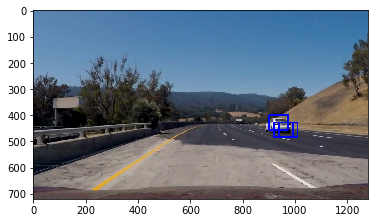

In [29]:
test_image = getRGBImage('./test_images/test9.jpg')
#Could use the img_size to make dynamic start stop pixel values. Deciding to hard code for now.
draw_image = np.copy(test_image)
img = draw_image.astype(np.float32) / 255

y_start_stop1 = [400, 512]
x_start_stop1 = [200, 1100]
xy_window1 = (72,56)
xy_overlap1 = (0.75,0.5)
windows1 = slide_window(img, x_start_stop=x_start_stop1, y_start_stop=y_start_stop1, 
                    xy_window=xy_window1, xy_overlap=xy_overlap1)

y_start_stop2 = [380, 592]
x_start_stop2 = [0, 1280]
xy_window2 = (120,100)
xy_overlap2 = (0.7,0.7)
windows2 = slide_window(img, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                    xy_window=xy_window2, xy_overlap=xy_overlap2)

y_start_stop3 = [400, 720]
x_start_stop3 = [None, None]
xy_window3 = (200,180)
xy_overlap3 = (0.75,0.5)
windows3 = slide_window(img, x_start_stop=x_start_stop3, y_start_stop=y_start_stop3, 
                    xy_window=xy_window3, xy_overlap=xy_overlap3)

all_windows = windows1 + windows2 + windows3


hot_windows = search_windows(img, all_windows, clf, X_scaler, color_space='YCrCb', 
                        spatial_size=(16,16), hist_bins=18, 
                        orient=8, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel='ALL', spatial_feat=True, 
                        hist_feat=True, hog_feat=True)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)
plt.imsave('./output_images/hot_windows.jpg', window_img)


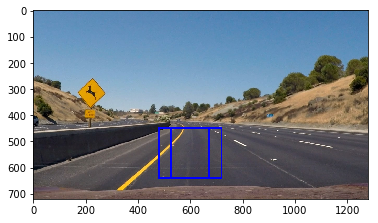

In [67]:
%matplotlib inline
ystart = 400
ystop = 720
scale = 3
test_image = getRGBImage('./test_images/test2.jpg')

out_img = find_cars(test_image, ystart, ystop, scale, clf, X_scaler, 8, 8, 2, (16,16), 24)

plt.imshow(out_img)

(720, 1280)


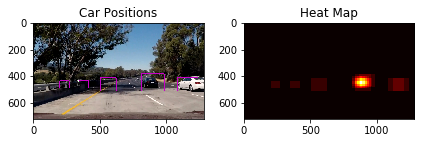

In [47]:
from scipy.ndimage.measurements import label
%matplotlib inline
test_image = getRGBImage('./test_images/test5.jpg')
img = test_image.astype(np.float32) / 255
heat = np.zeros_like(img[:,:,0]).astype(np.float)
print(heat.shape)

windows = get_windows(test_image)

hot_windows = search_windows(img, windows, clf, X_scaler, color_space='YCrCb', 
                        spatial_size=(16,16), hist_bins=18, 
                        orient=8, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel='ALL', spatial_feat=True, 
                        hist_feat=True, hog_feat=True)

heat = add_heat(heat, hot_windows)
heat = apply_threshold(heat, 0)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.imsave('./output_images/heat_map.jpg', heatmap, cmap='hot')
plt.imsave('./output_images/heat_map_labels.jpg', draw_img)

## Image pipeline

In [45]:
def process_image(img):
    global first_frame
    global heat
    global stored_heat
    global windows
    scaled_img = img.astype(np.float32) / 255
    hot_windows = search_windows(scaled_img, windows, clf, X_scaler, color_space='YCrCb', 
                            spatial_size=(16,16), hist_bins=18, 
                            orient=8, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True)
    #if (first_frame == True):
    
    stored_heat.append(hot_windows)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for hot_window_group in stored_heat:
        heat = add_heat(heat, hot_window_group)
    
    heat = apply_threshold(heat, 30)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    first_frame = False
    return draw_img

In [46]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_image = getRGBImage('./test_images/test6.jpg')
windows = get_windows(test_image)
first_frame = True
heat = []
stored_heat = deque(maxlen=40)

detection_output = 'detection_output.mp4'
clip1 = VideoFileClip('project_video.mp4')

yellow_clip = clip1.fl_image(process_image)
%time yellow_clip.write_videofile(detection_output, audio=False)

[MoviePy] >>>> Building video detection_output.mp4
[MoviePy] Writing video detection_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [27:10<00:01,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: detection_output.mp4 

Wall time: 27min 11s


In [102]:
print(1%10)
print(2%10)
print(10%10)
print(11%10)

1
2
0
1
